# News Analysis with LLM (Gemini)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("GEMINI_API_KEY")

if api_key is None:
    print("Error: GEMINI_API_KEY not found in .env file or environment variables.")
else:
    print("GEMINI_API_KEY loaded successfully.")

GEMINI_API_KEY loaded successfully.


In [2]:
import google.generativeai as genai
from tqdm import tqdm

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.5-flash-preview-04-17", generation_config=generation_config)

In [3]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [ ]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format (Don't forget to make space between the sections as shown):

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.Answer in 1-5 only, no explanation.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [5]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("../../DataCollection/Data/Trending/2025-05-27_22-43-20.csv")
display(df.head())

,publish_date,publish_time,title,body_text,url
0,2025-05-27,10:33,US Consumer bounces back sharply in May By Inv...,Investing.com -- Consumer confidence rebounded...,https://www.investing.com/news/economy-news/us...
1,2025-05-27,10:29,Eli Lilly expands pain pipeline with acquisiti...,Investing.com -- Eli Lilly and Company (NYSE: ...,https://www.investing.com/news/stock-market-ne...
2,2025-05-27,09:41,"Lynx: Risk priced in, Nvidia could surprise to...",Investing.com -- Nvidia stock could break out ...,https://www.investing.com/news/stock-market-ne...
3,2025-05-27,09:16,Trump Media & Technology Group Announces $2.5B...,Trump Media and Technology Group Corp. (Nasdaq...,https://www.investing.com/news/cryptocurrency-...
4,2025-05-27,09:15,SoundHound shares jump as Piper Sandler starts...,Investing.com -- Piper Sandler has initiated c...,https://www.investing.com/news/stock-market-ne...


In [7]:
df.isnull().sum()

publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [8]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)

In [9]:
print(df.head())

  publish_date publish_time  \
0   2025-05-27        10:33   
1   2025-05-27        10:29   
2   2025-05-27        09:41   
3   2025-05-27        09:16   
4   2025-05-27        09:15   

                                               title  \
0  US Consumer bounces back sharply in May By Inv...   
1  Eli Lilly expands pain pipeline with acquisiti...   
2  Lynx: Risk priced in, Nvidia could surprise to...   
3  Trump Media & Technology Group Announces $2.5B...   
4  SoundHound shares jump as Piper Sandler starts...   

                                           body_text  \
0  Investing.com -- Consumer confidence rebounded...   
1  Investing.com -- Eli Lilly and Company (NYSE: ...   
2  Investing.com -- Nvidia stock could break out ...   
3  Trump Media and Technology Group Corp. (Nasdaq...   
4  Investing.com -- Piper Sandler has initiated c...   

                                                 url  
0  https://www.investing.com/news/economy-news/us...  
1  https://www.investing.com/

In [ ]:
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    current_stock = row.get("ticker", "news")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])

    try:
        response = generate_content_with_rate_limit(filled_prompt)
        finalprediction = response.strip()
        if not finalprediction:
            print(f"Row {index}: LLM returned an empty string.")
            predicted.append("LLM_EMPTY_RESPONSE")
        else:
            predicted.append(finalprediction)
    except ValueError as ve:
        print(f"Row {index}: ValueError - {ve}. Appending 'ERROR_VALUE_ERROR'.")
        predicted.append("ERROR_VALUE_ERROR")
        continue
    except Exception as e:
        if "429 Too Many Requests" in str(e) or "quota" in str(e).lower():
            print(f"Row {index}: Rate Limit Exceeded or Quota Error - {e}. Appending 'ERROR_RATE_LIMIT'.")
            predicted.append("ERROR_RATE_LIMIT")
        elif "safety" in str(e).lower() or "blocked" in str(e).lower():
             print(f"Row {index}: Content Safety/Blocked - {e}. Appending 'ERROR_SAFETY_BLOCKED'.")
             predicted.append("ERROR_SAFETY_BLOCKED")
        else:
            print(f"Row {index}: Unexpected Error - {e}. Appending 'ERROR_UNEXPECTED'.")
            predicted.append("ERROR_UNEXPECTED")
        continue

Prompting: 100%|██████████| 20/20 [01:59<00:00,  5.96s/it]


In [11]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [12]:
print(df["title"][2],'\n\n',predicted[2])

Lynx: Risk priced in, Nvidia could surprise to the upside By Investing.com 

 **Sentiment:**
Positive

**Summary:**
Analyst firm Lynx Equity raised its price target for Nvidia and maintains a bullish stance, expecting the stock to break out to new highs after its upcoming earnings report. The firm believes previously highlighted risks are now priced in and sees potential for an upside surprise due to successful navigation of challenges, capacity expansion, new growth vectors like Edge AI, and mitigated tariff risks.

**Reasoning for Sentiment:**
The sentiment is positive because the article reports an analyst firm raising its price target, expressing a bullish outlook, and citing multiple positive factors like risk mitigation, capacity expansion, and new growth areas as reasons for expecting an upside surprise and new highs for the stock.

**Importance to Stock All_news:**
5

**Reasoning for Importance:**
This news is highly important as it represents a bullish analyst upgrade with a r

In [13]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [14]:
df[df["importance"]== "5"][["publish_date","title", "sentiment","importance", "summary"]]

,publish_date,title,sentiment,importance,summary
0,2025-05-27,US Consumer bounces back sharply in May By Inv...,Positive,5,US consumer confidence rebounded sharply in Ma...
1,2025-05-27,Eli Lilly expands pain pipeline with acquisiti...,Positive,5,Eli Lilly is acquiring SiteOne Therapeutics fo...
2,2025-05-27,"Lynx: Risk priced in, Nvidia could surprise to...",Positive,5,Analyst firm Lynx Equity raised its price targ...
3,2025-05-27,Trump Media & Technology Group Announces $2.5B...,Positive,5,Trump Media & Technology Group announced a pri...
4,2025-05-27,SoundHound shares jump as Piper Sandler starts...,Positive,5,Piper Sandler initiated coverage on SoundHound...
6,2025-05-27,"Next 300 points likely up for the S&P 500, say...",Positive,5,"JPMorgan analysts are bullish on the S&P 500, ..."
8,2025-05-27,New surveys show declining interest in EVs and...,Negative,5,New surveys from UBS and Stifel indicate decli...
9,2025-05-27,Temu owner PDD Holdings shares fall sharply on...,Negative,5,"PDD Holdings, owner of Temu, reported first-qu..."
10,2025-05-27,Citi sees up to 8% downside for Stoxx 600 on T...,Negative,5,Citi analysts warn that European equities (Sto...
11,2025-05-27,What could be the impact of a 50% tariff on EU...,Negative,5,"According to UBS, a potential 50% US tariff on..."


In [15]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [16]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

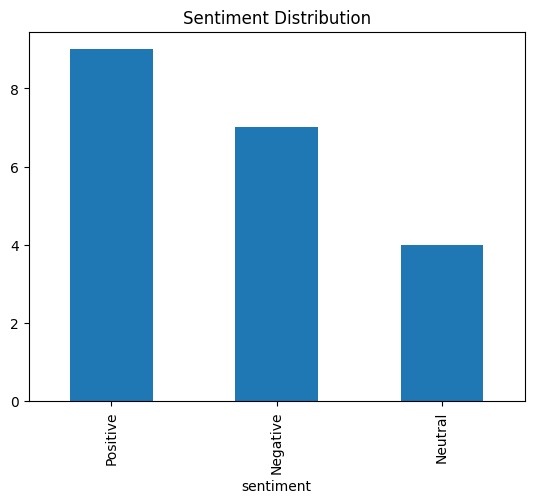

In [17]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

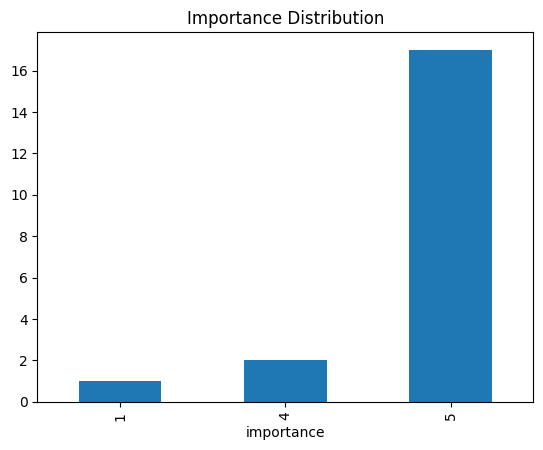

In [18]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [19]:
TICKER=current_stock

In [20]:
df[df['sentiment']=='']
df = df[df['sentiment'] != '']

In [21]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [22]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for All_news: 0.05


In [ ]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Gemini/Gemini_{TICKER}_{date_time}.csv", index=False)